<a href="https://colab.research.google.com/github/emsmullen/VirtueSemantics/blob/main/Copy_of_VirtueSemantics_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Set Up

In [1]:
#import packages
import sys, os, random, requests, json #connects with interpreter; interacts with os; HTTP requests; JSON data
import pandas as pd #data structures and analysis tools
import numpy as np #for multi-dimensional data and mathematical functions (arrays)
import scipy.stats as st #complex computations (numerical)
import matplotlib.pyplot as plt #for plotting data
import sklearn.decomposition #for PCA
import git
from google.colab import drive, data_table, userdata #access Google Drive; interactive pandas dataframes; secrets

In [11]:
#commit to git repo
pat = userdata.get('git')
username = 'emsmullen'
repo = 'VirtueSemantics'
!git clone https://{pat}@github.com/{username}/{repo}.git
#!git remote add origin https://{pat}@github.com/{username}/{repo}.git
#!git remote add origin https://github.com/emsmullen/VirtueSemantics.git

fatal: destination path 'VirtueSemantics' already exists and is not an empty directory.


In [2]:
#set up paths for local modules and data sources
drive.mount('/content/drive',force_remount=True)
sys.path.append('/content/drive/MyDrive/')
stim_path = '/content/drive/MyDrive/'

Mounted at /content/drive


In [3]:
#set environment variable with API key and github token
%env OPENAI_API_KEY = userdata.get('OAI') #APIs connect software applications
%env github_token = userdata.get('git')

env: OPENAI_API_KEY=userdata.get('OAI') #APIs connect software applications
env: github_token=userdata.get('git')


In [ ]:
# commit to github
!git clone https://{pat}@github.com/username/repo.git

In [ ]:
#read in stimuli stored on google drive (must add this file to drive)
#action_data = pd.read_csv(stim_path+"ValueSemantics/actions_human_complete.csv")
action_data = pd.read_csv(stim_path+"ValueSemantics/action_neurips.csv")
action_list_all = action_data["actions"].tolist()
#action_list_all = action_data[:,0].tolist()
n_items = len(action_list_all)

virtue_data = pd.read_csv(stim_path+"ValueSemantics/excess_deficiency_mean.csv")
virtue_list_all = virtue_data["excess"].tolist() + virtue_data["deficiency"].tolist() + virtue_data["mean"].tolist()
n_virtues = len(virtue_list_all)

In [ ]:
excess_list = virtue_data["excess"].tolist()
deficiency_list = virtue_data["deficiency"].tolist()
mean_list = virtue_data["mean"].tolist()

In [ ]:
virtue_data

,excess,mean,deficiency
0,rashness,courage,cowardice
1,licentiousness,temperance,insensibility
2,prodigality,liberality,meanness
3,vulgarity,magnificence,pettiness
4,vanity,magnanimity,pusillanimity
5,empty vanity,pride,unambitiousness
6,irascibility,patience,lack of spirit
7,boastfulness,truthfulness,mock modesty
8,buffoonery,wittiness,boorishness
9,obsequiousness,friendliness,cantankerousness


# Embedding Projections

In [ ]:
#@title define functions
def getEmbeddings(text):
    url = 'https://api.openai.com/v1/embeddings'
    headers = {
      "Content-Type": "application/json",
      "Authorization": userdata.get('OAI')
      }
    data = {
        "input": text,
        "model": "text-embedding-ada-002"
    }
    response = requests.post(url, headers=headers, json=data)

    return response.json()

#function to get the difference of embeddings of two texts
def return_embeddings_diff(attributes_a, attributes_b):
  '''
  Pass two sets of attributes and get all vector differences of all a-b combinations
  NOTE: The distinction between high and low embeddings is automatically made by given data
  '''
  emb_high = pd.DataFrame()
  emb_low = pd.DataFrame()

  #loop through each attribute set and save the embeddings in two dataframes
  for a in range(len(attributes_a)):
    #get embedding of the high, low, and compute difference
    this_emb = getEmbeddings(attributes_a[a])
    emb_high.insert(loc=0, column=a, value=this_emb["data"][0]["embedding"])

  for b in range(len(attributes_b)):
    #get embedding of the high, low, and compute difference
    this_emb = getEmbeddings(attributes_b[b])
    emb_low.insert(loc=0, column=b, value=this_emb["data"][0]["embedding"])

  #get all differences
  vector_diff = pd.DataFrame()

  #report correlations
  print(emb_low.corr()) #correlations are higher when closer to 1
  print(emb_high.corr())

  for a in range(len(attributes_a)):
    for b in range(len(attributes_b)):
      this_col = str(a)+'_'+str(b)
      vector_diff.insert(loc=0, column=this_col, value=emb_high[a] - emb_low[b])

  return(vector_diff.mean(axis=1)) #pandas series; contains average value per row for overall differences in embeddings


def return_list_embeddings(alist):
  '''
  get embeddings for a list of items
  '''
  n_df = pd.DataFrame()
  for i in alist:
    this_em = getEmbeddings(i)["data"][0]["embedding"]
    n_df.insert(loc=0, column=i, value=this_em, allow_duplicates=True)

  return (n_df)


def get_projections(stim_list, moral_v, hedonic_v, movement_v):
  '''
  get projections for list of items
  '''
  #construct dataframe to save items
  projection_df = pd.DataFrame(index=stim_list, columns=['moral_v','hedonic_v','movement_v'], data=0)

  #loop through items to get embeddings in moral, hedonic, and movement vector directions

  for a in stim_list:
    this_em = getEmbeddings(a)["data"][0]["embedding"]
    projection_moral = np.inner(np.array(this_em),np.array(moral_v))
    projection_hedonic = np.inner(np.array(this_em),np.array(hedonic_v))
    projection_movement = np.inner(np.array(this_em),np.array(movement_v))
    projection_df.loc[a, "moral_v"] = projection_moral
    projection_df.loc[a, "hedonic_v"] = projection_hedonic
    projection_df.loc[a, "movement_v"] = projection_movement

  return projection_df

In [ ]:
#redefine to be more general - feed in dataframe of axes to project actions on and return projections
def get_projections_df(stim_list, moral_v, hedonic_v, movement_v):
  '''
  get projections for list of items onto dataframe of vectors
  '''
  #construct dataframe to save items
  projection_df = pd.DataFrame(index=stim_list, columns=['moral_v','hedonic_v','movement_v'], data=0)

  #loop through items to get embeddings in moral, hedonic, and movement vector directions

  for a in stim_list:
    this_em = getEmbeddings(a)["data"][0]["embedding"]
    projection_moral = np.inner(np.array(this_em),np.array(moral_v))
    projection_hedonic = np.inner(np.array(this_em),np.array(hedonic_v))
    projection_movement = np.inner(np.array(this_em),np.array(movement_v))
    projection_df.loc[a, "moral_v"] = projection_moral
    projection_df.loc[a, "hedonic_v"] = projection_hedonic
    projection_df.loc[a, "movement_v"] = projection_movement

  return projection_df

In [ ]:
virtue_embeddings = return_list_embeddings(virtue_list_all)

## generate embeddings

In [ ]:
#virtues_PCA = sklearn.decomposition.PCA(virtue_embeddings,n_components=3)
pca = sklearn.decomposition.PCA(n_components=3)
pca.fit(virtue_embeddings)
print(pca.explained_variance_ratio_)
pca.fit_transform(virtue_embeddings)

[0.82467433 0.01410767 0.0125143 ]


array([[-0.05173792,  0.00637147,  0.00251083],
       [-0.05160807,  0.01002551, -0.01241943],
       [ 0.0671698 ,  0.00702784, -0.02060437],
       ...,
       [-0.09018547,  0.00443659,  0.01770667],
       [ 0.05626571, -0.00072268, -0.02218571],
       [-0.15904461,  0.00272192,  0.00473151]])

In [ ]:
virtue_emb_mean = []
for virtue in mean_list:
  virtue_emb = getEmbeddings(virtue)["data"][0]["embedding"]
  virtue_emb_mean.append(virtue_emb)

In [ ]:
virtue_emb_mean_df = pd.DataFrame(data=virtue_emb_mean,index=mean_list).transpose()
virtue_emb_mean_df

,courage,temperance,liberality,magnificence,magnanimity,pride,patience,truthfulness,wittiness,friendliness,modesty,righteous indignation
0,-0.012774,-0.004112,-0.005600,-0.008041,-0.004328,0.000002,-0.004526,-0.010826,-0.008253,0.004982,-0.002438,-0.011200
1,-0.030501,-0.012391,-0.014227,0.007849,-0.016999,-0.023082,0.000872,-0.012531,-0.008199,-0.001430,-0.011328,-0.016460
2,-0.017832,0.007030,-0.003365,0.018468,0.019102,0.008849,0.003711,-0.005146,0.001512,0.005881,0.004673,-0.005365
3,-0.012879,-0.033489,-0.040953,-0.037228,-0.030091,-0.031573,-0.029560,-0.020114,-0.007872,-0.025036,-0.017756,-0.025483
4,0.009165,-0.017670,-0.018043,0.005353,-0.004874,0.006235,0.006512,-0.005239,-0.004410,0.007567,-0.022807,-0.012689
...,...,...,...,...,...,...,...,...,...,...,...,...
1531,0.053979,0.035099,0.041091,0.056267,0.086881,0.045696,0.019887,0.015701,0.057476,0.037464,0.045173,0.056259
1532,0.023413,0.022259,0.000922,-0.000325,-0.001485,0.007445,0.015902,-0.000435,0.004771,0.015217,-0.008217,-0.004270
1533,-0.020937,-0.009908,-0.025233,-0.024567,-0.031828,-0.028843,-0.008729,-0.001844,-0.019537,-0.027110,-0.005640,-0.009368
1534,0.002782,-0.008064,0.018306,-0.003384,0.002696,0.020715,0.016720,0.016369,0.004580,-0.001856,0.002448,0.010565


In [ ]:
virtue_emb_diff_df

mean,courage,temperance,liberality,magnificence,magnanimity,pride,patience,truthfulness,wittiness,friendliness,modesty,righteous indignation
0,-0.006090,0.003987,0.000592,-0.002930,-0.002703,-0.003718,-0.003945,-0.000537,-0.000228,-0.000519,-0.002082,-0.005421
1,0.001181,0.003991,0.002449,0.002218,-0.004644,-0.006362,-0.000495,0.005848,-0.002428,0.001882,-0.002792,-0.010326
2,0.007664,0.000153,-0.010242,-0.007068,0.003739,-0.001336,-0.003079,0.005283,-0.000721,-0.004651,0.001940,0.002773
3,0.010169,-0.002252,-0.006810,-0.004634,0.002451,-0.002528,-0.001454,0.007776,-0.008314,-0.002707,0.002917,-0.001030
4,0.010463,0.000464,-0.006486,-0.002721,-0.000434,-0.002617,-0.000494,0.004870,-0.004848,0.001558,0.001072,-0.000450
...,...,...,...,...,...,...,...,...,...,...,...,...
1531,-0.003444,-0.001823,0.001428,0.000370,-0.000353,-0.001117,0.002441,0.001912,0.004286,0.000947,0.001488,-0.000699
1532,0.006610,-0.000931,-0.002173,-0.005846,0.000746,-0.002792,0.002191,0.001349,-0.006021,-0.000557,0.004108,-0.004619
1533,-0.001310,0.001312,0.003797,0.001494,-0.001571,-0.002002,0.000293,0.003828,0.000355,0.002304,-0.001145,-0.004628
1534,0.003797,0.001927,-0.003327,-0.004012,-0.003374,-0.006605,0.003321,0.007672,-0.001658,0.001891,0.002076,-0.006523


In [ ]:
#cosine similarity between virtue embedding by mean and difference between extremes


cosine = np.dot(virtue_emb_diff_df['courage'],virtue_emb_mean_df['courage'])/(np.linalg.norm(virtue_emb_mean_df['courage'])* np.linalg.norm(virtue_emb_mean_df['courage']))


In [ ]:
cosine

-0.0018304056847011235

In [ ]:
#moral value projection onto virtues (or virtues onto moral)


In [ ]:
#using virtue vectors as space to project action embeddings on
# Initializing lists
mean_list = virtue_data['mean'].tolist()
excess_list = virtue_data['excess'].tolist()
deficiency_list = virtue_data['deficiency'].tolist()

# Construct variables of list elements
# using dict() + zip()
mean_excess_dict = dict(zip(mean_list,excess_list))
mean_deficiency_dict = dict(zip(mean_list, deficiency_list))

virtue_emb_diffs = []
for virtue in mean_list:
  temp_excess_list = mean_excess_dict[virtue]
  temp_deficiency_list = mean_deficiency_dict[virtue]
  emb_diff = return_embeddings_diff(temp_excess_list, temp_deficiency_list)
  virtue_emb_diffs.append(emb_diff)

virtue_emb_mean = []
for virtue in mean_list:
  virtue_emb = getEmbeddings(virtue)["data"][0]["embedding"]
  virtue_emb_mean.append(virtue_emb)

          8         7         6         5         4         3         2  \
8  1.000000  0.875951  0.888051  0.893943  0.827073  0.893327  0.861238   
7  0.875951  1.000000  0.877011  0.954035  0.837328  0.908790  0.879508   
6  0.888051  0.877011  1.000000  0.891153  0.819285  0.895084  0.875005   
5  0.893943  0.954035  0.891153  1.000000  0.840427  0.920386  0.878731   
4  0.827073  0.837328  0.819285  0.840427  1.000000  0.834542  0.851146   
3  0.893327  0.908790  0.895084  0.920386  0.834542  1.000000  0.871189   
2  0.861238  0.879508  0.875005  0.878731  0.851146  0.871189  1.000000   
1  0.874518  0.846976  0.885113  0.862010  0.821599  0.879171  0.859677   
0  0.875951  1.000000  0.877011  0.954035  0.837328  0.908790  0.879508   

          1         0  
8  0.874518  0.875951  
7  0.846976  1.000000  
6  0.885113  0.877011  
5  0.862010  0.954035  
4  0.821599  0.837328  
3  0.879171  0.908790  
2  0.859677  0.879508  
1  1.000000  0.846976  
0  0.846976  1.000000  
         

<ipython-input-10-9a4e52498519>:46: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vector_diff.insert(loc=0, column=this_col, value=emb_high[a] - emb_low[b])
<ipython-input-10-9a4e52498519>:46: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vector_diff.insert(loc=0, column=this_col, value=emb_high[a] - emb_low[b])
<ipython-input-10-9a4e52498519>:46: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once 

          7         6         5         4         3         2         1  \
7  1.000000  1.000000  0.885007  0.907609  0.907609  0.895990  0.885007   
6  1.000000  1.000000  0.885007  0.907609  0.907609  0.895990  0.885007   
5  0.885007  0.885007  1.000000  0.879890  0.879890  0.893327  1.000000   
4  0.907609  0.907609  0.879890  1.000000  1.000000  0.882006  0.879890   
3  0.907609  0.907609  0.879890  1.000000  1.000000  0.882006  0.879890   
2  0.895990  0.895990  0.893327  0.882006  0.882006  1.000000  0.893327   
1  0.885007  0.885007  1.000000  0.879890  0.879890  0.893327  1.000000   
0  0.888777  0.888777  0.862380  0.884373  0.884373  0.866493  0.862380   

          0  
7  0.888777  
6  0.888777  
5  0.862380  
4  0.884373  
3  0.884373  
2  0.866493  
1  0.862380  
0  1.000000  
          10        9         8         7         6         5         4   \
10  1.000000  0.869578  0.875731  0.865171  0.859033  0.863602  0.875731   
9   0.869578  1.000000  0.880384  0.874651  0.

<ipython-input-10-9a4e52498519>:46: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vector_diff.insert(loc=0, column=this_col, value=emb_high[a] - emb_low[b])
<ipython-input-10-9a4e52498519>:46: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vector_diff.insert(loc=0, column=this_col, value=emb_high[a] - emb_low[b])
<ipython-input-10-9a4e52498519>:46: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once 

          13        12        11        10        9         8         7   \
13  1.000000  0.880384  0.851836  0.880384  0.895237  0.893451  0.827963   
12  0.880384  1.000000  0.819285  1.000000  0.885897  0.882786  0.829000   
11  0.851836  0.819285  1.000000  0.819285  0.855821  0.845302  0.807833   
10  0.880384  1.000000  0.819285  1.000000  0.885897  0.882786  0.829000   
9   0.895237  0.885897  0.855821  0.885897  1.000000  0.901284  0.836545   
8   0.893451  0.882786  0.845302  0.882786  0.901284  1.000000  0.845763   
7   0.827963  0.829000  0.807833  0.829000  0.836545  0.845763  1.000000   
6   0.886070  0.882735  0.841369  0.882735  0.891682  0.898934  0.831315   
5   0.864881  0.885113  0.821599  0.885113  0.875173  0.871537  0.839888   
4   0.827963  0.829000  0.807833  0.829000  0.836545  0.845763  1.000000   
3   0.869500  0.864984  0.829084  0.864984  0.882703  0.897954  0.840920   
2   0.878441  0.877011  0.837328  0.877011  0.881331  0.883723  0.817363   
1   0.874070

<ipython-input-10-9a4e52498519>:46: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vector_diff.insert(loc=0, column=this_col, value=emb_high[a] - emb_low[b])
<ipython-input-10-9a4e52498519>:46: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vector_diff.insert(loc=0, column=this_col, value=emb_high[a] - emb_low[b])
<ipython-input-10-9a4e52498519>:46: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once 

          11        10        9         8         7         6         5   \
11  1.000000  0.869578  0.871650  0.860448  0.853287  0.864186  0.855523   
10  0.869578  1.000000  0.893451  0.874542  0.878714  0.864881  0.874339   
9   0.871650  0.893451  1.000000  0.885007  0.893102  0.871537  0.888777   
8   0.860448  0.874542  0.885007  1.000000  0.893943  0.874518  0.862380   
7   0.853287  0.878714  0.893102  0.893943  1.000000  0.862010  0.865116   
6   0.864186  0.864881  0.871537  0.874518  0.862010  1.000000  0.843661   
5   0.855523  0.874339  0.888777  0.862380  0.865116  0.843661  1.000000   
4   0.824581  0.827963  0.845763  0.840638  0.831860  0.839888  0.823352   
3   0.869606  0.869500  0.897954  0.863703  0.862572  0.876147  0.876375   
2   0.842102  0.878441  0.883723  0.875951  0.954035  0.846976  0.859759   
1   0.864186  0.864881  0.871537  0.874518  0.862010  1.000000  0.843661   
0   0.855523  0.874339  0.888777  0.862380  0.865116  0.843661  1.000000   

          4

<ipython-input-10-9a4e52498519>:46: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vector_diff.insert(loc=0, column=this_col, value=emb_high[a] - emb_low[b])
<ipython-input-10-9a4e52498519>:46: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vector_diff.insert(loc=0, column=this_col, value=emb_high[a] - emb_low[b])
<ipython-input-10-9a4e52498519>:46: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once 

          10        9         8         7         6         5         4   \
10  1.000000  1.000000  0.885007  0.907609  0.896101  1.000000  0.882786   
9   1.000000  1.000000  0.885007  0.907609  0.896101  1.000000  0.882786   
8   0.885007  0.885007  1.000000  0.879890  0.871385  0.885007  0.888051   
7   0.907609  0.907609  0.879890  1.000000  0.883069  0.907609  0.873908   
6   0.896101  0.896101  0.871385  0.883069  1.000000  0.896101  0.877220   
5   1.000000  1.000000  0.885007  0.907609  0.896101  1.000000  0.882786   
4   0.882786  0.882786  0.888051  0.873908  0.877220  0.882786  1.000000   
3   0.845302  0.845302  0.827073  0.838587  0.857831  0.845302  0.819285   
2   0.871537  0.871537  0.874518  0.876204  0.865263  0.871537  0.885113   
1   0.871537  0.871537  0.874518  0.876204  0.865263  0.871537  0.885113   
0   0.897277  0.897277  0.886817  0.881831  0.888502  0.897277  0.900037   

          3         2         1         0   
10  0.845302  0.871537  0.871537  0.897277

<ipython-input-10-9a4e52498519>:46: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vector_diff.insert(loc=0, column=this_col, value=emb_high[a] - emb_low[b])
<ipython-input-10-9a4e52498519>:46: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vector_diff.insert(loc=0, column=this_col, value=emb_high[a] - emb_low[b])
<ipython-input-10-9a4e52498519>:46: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once 

          15        14        13        12        11        10        9   \
15  1.000000  1.000000  0.885007  0.907524  1.000000  0.839237  0.871537   
14  1.000000  1.000000  0.885007  0.907524  1.000000  0.839237  0.871537   
13  0.885007  0.885007  1.000000  0.879837  0.885007  0.850529  0.874518   
12  0.907524  0.907524  0.879837  1.000000  0.907524  0.844143  0.876123   
11  1.000000  1.000000  0.885007  0.907524  1.000000  0.839237  0.871537   
10  0.839237  0.839237  0.850529  0.844143  0.839237  1.000000  0.854596   
9   0.871537  0.871537  0.874518  0.876123  0.871537  0.854596  1.000000   
8   0.845302  0.845302  0.827073  0.838508  0.845302  0.824595  0.821599   
7   0.885007  0.885007  1.000000  0.879837  0.885007  0.850529  0.874518   
6   0.897954  0.897954  0.863703  0.895892  0.897954  0.825326  0.876147   
5   0.907609  0.907609  0.879890  0.999999  0.907609  0.844173  0.876204   
4   0.895990  0.895990  0.893327  0.881929  0.895990  0.841325  0.879171   
3   0.893451

<ipython-input-10-9a4e52498519>:46: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vector_diff.insert(loc=0, column=this_col, value=emb_high[a] - emb_low[b])
<ipython-input-10-9a4e52498519>:46: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vector_diff.insert(loc=0, column=this_col, value=emb_high[a] - emb_low[b])
<ipython-input-10-9a4e52498519>:46: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once 

          12        11        10        9         8         7         6   \
12  1.000000  1.000000  0.885007  0.907609  1.000000  1.000000  0.885007   
11  1.000000  1.000000  0.885007  0.907609  1.000000  1.000000  0.885007   
10  0.885007  0.885007  1.000000  0.879890  0.885007  0.885007  1.000000   
9   0.907609  0.907609  0.879890  1.000000  0.907609  0.907609  0.879890   
8   1.000000  1.000000  0.885007  0.907609  1.000000  1.000000  0.885007   
7   1.000000  1.000000  0.885007  0.907609  1.000000  1.000000  0.885007   
6   0.885007  0.885007  1.000000  0.879890  0.885007  0.885007  1.000000   
5   0.887996  0.887996  0.860621  0.890595  0.887996  0.887996  0.860621   
4   0.885007  0.885007  1.000000  0.879890  0.885007  0.885007  1.000000   
3   0.888777  0.888777  0.862380  0.884373  0.888777  0.888777  0.862380   
2   0.895990  0.895990  0.893327  0.882006  0.895990  0.895990  0.893327   
1   0.896101  0.896101  0.871385  0.883069  0.896101  0.896101  0.871385   
0   1.000000

In [ ]:
virtue_emb_diff_df = pd.DataFrame(np.array(virtue_emb_diffs).T, columns=virtue_data['mean'])

mean,courage,temperance,liberality,magnificence,magnanimity,pride,patience,truthfulness,wittiness,friendliness,modesty,righteous indignation
0,-0.006090,0.003987,0.000592,-0.002930,-0.002703,-0.003718,-0.003945,-0.000537,-0.000228,-0.000519,-0.002082,-0.005421
1,0.001181,0.003991,0.002449,0.002218,-0.004644,-0.006362,-0.000495,0.005848,-0.002428,0.001882,-0.002792,-0.010326
2,0.007664,0.000153,-0.010242,-0.007068,0.003739,-0.001336,-0.003079,0.005283,-0.000721,-0.004651,0.001940,0.002773
3,0.010169,-0.002252,-0.006810,-0.004634,0.002451,-0.002528,-0.001454,0.007776,-0.008314,-0.002707,0.002917,-0.001030
4,0.010463,0.000464,-0.006486,-0.002721,-0.000434,-0.002617,-0.000494,0.004870,-0.004848,0.001558,0.001072,-0.000450
...,...,...,...,...,...,...,...,...,...,...,...,...
1531,-0.003444,-0.001823,0.001428,0.000370,-0.000353,-0.001117,0.002441,0.001912,0.004286,0.000947,0.001488,-0.000699
1532,0.006610,-0.000931,-0.002173,-0.005846,0.000746,-0.002792,0.002191,0.001349,-0.006021,-0.000557,0.004108,-0.004619
1533,-0.001310,0.001312,0.003797,0.001494,-0.001571,-0.002002,0.000293,0.003828,0.000355,0.002304,-0.001145,-0.004628
1534,0.003797,0.001927,-0.003327,-0.004012,-0.003374,-0.006605,0.003321,0.007672,-0.001658,0.001891,0.002076,-0.006523


In [ ]:
# compute df of action embeddings so i don't have to keep calling! sheesh
action_embeddings = []

for a in action_list_all:
  this_em = getEmbeddings(a)["data"][0]["embedding"]
  action_embeddings.append(this_em)

action_embeddings_df = pd.DataFrame(action_embeddings, index=action_list_all)
action_embeddings_df.transpose()

,running a marathon for charity,giving my employees a day off to go to the spa,serving food to unhoused people in a soup kitchen,teaching English to refugees,cleaning up litter in a rough neighborhood,serving on a jury,running a marathon for fitness,winning millions in the lottery,mowing the lawn,sitting in a chair,...,going swing dancing,watching your favorite movie,painting a wall,listening to local news,punching myself in the face,dropping and breaking my phone,taking candy from a baby,lying on my taxes to get a higher return,punching my friend in the face,losing borrowed book
0,-0.015271,-0.015827,0.000996,-0.001945,0.008113,-0.016537,-0.016121,-0.015166,-0.010816,-0.006440,...,-0.031146,-0.013596,-0.005681,-0.015399,-0.036107,-0.037175,-0.013059,-0.022622,-0.033868,-0.016733
1,-0.024870,-0.000501,-0.030625,-0.019591,0.008490,-0.032151,-0.017443,-0.010569,0.003959,-0.007232,...,-0.017363,-0.026425,0.022816,0.014974,0.006485,-0.004561,-0.024290,-0.025695,-0.009288,-0.015275
2,-0.009293,0.004827,-0.009774,-0.018411,-0.012074,-0.012781,0.001669,0.012544,-0.006759,-0.019028,...,0.005996,0.003505,-0.006162,0.019232,0.003962,0.001783,0.001298,-0.003259,0.008841,-0.007696
3,-0.027639,-0.042665,-0.003279,-0.033269,0.003670,-0.025562,-0.016540,-0.021508,-0.018645,-0.016064,...,-0.009940,-0.043693,0.004700,-0.030665,-0.001913,-0.012275,-0.038043,-0.049125,-0.012182,-0.017913
4,-0.017308,-0.009868,-0.004894,-0.006939,-0.010381,-0.029023,-0.014260,-0.049753,-0.021075,-0.000484,...,-0.004378,-0.016091,-0.014326,-0.006134,-0.011438,-0.019704,-0.037816,-0.026060,-0.004273,-0.030404
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1531,0.012994,0.010790,0.029835,0.008172,0.004347,0.032535,-0.002197,0.037810,0.006854,0.003165,...,0.023164,0.027474,0.002895,0.027880,0.018512,0.009169,0.031337,0.011591,0.018798,0.014422
1532,-0.000037,-0.004301,-0.030230,-0.013507,0.007075,0.002407,0.012506,0.003590,0.016619,0.009854,...,0.016502,0.007265,-0.011042,-0.001266,-0.033925,0.005855,0.006076,0.005691,-0.007774,0.001638
1533,-0.016975,-0.003616,-0.012274,-0.024230,-0.013740,-0.019498,-0.019804,-0.026237,0.001254,-0.005428,...,-0.028427,0.006651,-0.005717,-0.003303,-0.002740,-0.000981,0.005789,-0.000544,-0.010968,-0.018525
1534,-0.017334,0.005476,-0.010800,-0.004593,-0.015697,-0.010781,0.000584,-0.002570,0.020303,0.009205,...,0.002495,0.011179,0.020278,-0.018675,0.024811,-0.012427,-0.013941,0.005864,-0.001617,0.010319


In [ ]:
virtues_list = list(virtue_emb_diff_df.columns.values)

def get_projections(stim_list, virtues):
  #construct dataframe to save items
  projection_df_ctl = pd.DataFrame(index=action_list_all, columns=virtues_list, data=0)

  for a in action_list_all:
    for virtue in virtues_list:
      this_em = getEmbeddings(a)["data"][0]["embedding"]
      projection_temp = np.inner(np.array(this_em),np.array(virtue_emb_diff_df[virtue]))
      projection_df_ctl.loc[a, virtue] = projection_temp

  return projection_df_ctl

In [ ]:
action_embeddings_df = pd.DataFrame(action_embeddings, index=action_list_all).transpose()

,courage,temperance,liberality,magnificence,magnanimity,pride,patience,truthfulness,wittiness,friendliness,modesty,righteous indignation
0,-0.012774,-0.004112,-0.005600,-0.008041,-0.004328,0.000002,-0.004526,-0.010826,-0.008253,0.004982,-0.002438,-0.011200
1,-0.030501,-0.012391,-0.014227,0.007849,-0.016999,-0.023082,0.000872,-0.012531,-0.008199,-0.001430,-0.011328,-0.016460
2,-0.017832,0.007030,-0.003365,0.018468,0.019102,0.008849,0.003711,-0.005146,0.001512,0.005881,0.004673,-0.005365
3,-0.012879,-0.033489,-0.040953,-0.037228,-0.030091,-0.031573,-0.029560,-0.020114,-0.007872,-0.025036,-0.017756,-0.025483
4,0.009165,-0.017670,-0.018043,0.005353,-0.004874,0.006235,0.006512,-0.005239,-0.004410,0.007567,-0.022807,-0.012689
...,...,...,...,...,...,...,...,...,...,...,...,...
1531,0.053979,0.035099,0.041091,0.056267,0.086881,0.045696,0.019887,0.015701,0.057476,0.037464,0.045173,0.056259
1532,0.023413,0.022259,0.000922,-0.000325,-0.001485,0.007445,0.015902,-0.000435,0.004771,0.015217,-0.008217,-0.004270
1533,-0.020937,-0.009908,-0.025233,-0.024567,-0.031828,-0.028843,-0.008729,-0.001844,-0.019537,-0.027110,-0.005640,-0.009368
1534,0.002782,-0.008064,0.018306,-0.003384,0.002696,0.020715,0.016720,0.016369,0.004580,-0.001856,0.002448,0.010565


In [ ]:
#compare embeddings of mean virtues versus embeddings of extreme differences

In [ ]:
#compare graphs

In [ ]:
action_df_all_virtues

,courage,temperance,liberality,magnificence,magnanimity,pride,patience,truthfulness,wittiness,friendliness,modesty,righteous indignation
running a marathon for charity,0.001065,0.000348,0.001058,0.000040,0.002318,-0.002761,0.000239,0.001662,-0.004166,-0.001892,0.000511,-0.002514
giving my employees a day off to go to the spa,-0.002030,-0.001505,0.003233,-0.001397,0.003993,0.002242,0.001123,-0.000529,-0.003010,-0.002290,0.000812,0.002880
serving food to unhoused people in a soup kitchen,0.000642,0.000295,-0.000093,-0.000363,0.003499,-0.001246,-0.001621,0.001076,-0.004210,-0.001834,0.000553,-0.000276
teaching English to refugees,-0.001724,0.001175,-0.000701,-0.004318,0.003527,-0.000773,-0.000387,0.001634,-0.001717,-0.001550,-0.000706,-0.000279
cleaning up litter in a rough neighborhood,-0.002128,-0.000536,0.003132,0.002127,0.002106,-0.001418,0.000763,0.002503,-0.001581,-0.002973,-0.000766,-0.000445
serving on a jury,0.000879,-0.000618,-0.001575,0.001746,0.004394,-0.001545,0.002442,0.004226,-0.002881,-0.003009,0.000818,0.002469
running a marathon for fitness,0.000138,-0.000894,-0.000521,-0.002778,0.002456,-0.003430,0.002385,0.002297,-0.004158,-0.001956,0.000407,-0.003648
winning millions in the lottery,-0.003691,-0.000883,0.003697,0.002264,0.001622,-0.000028,0.001834,-0.001502,-0.002951,-0.002152,0.000540,0.000939
mowing the lawn,-0.003585,-0.001994,-0.000487,0.001966,-0.000344,-0.001966,0.004155,0.000529,-0.003177,-0.003892,-0.002907,-0.001609
sitting in a chair,0.004678,-0.001247,0.001029,-0.001456,0.001339,-0.003676,0.003233,0.004822,-0.008038,0.000018,0.001746,-0.003960


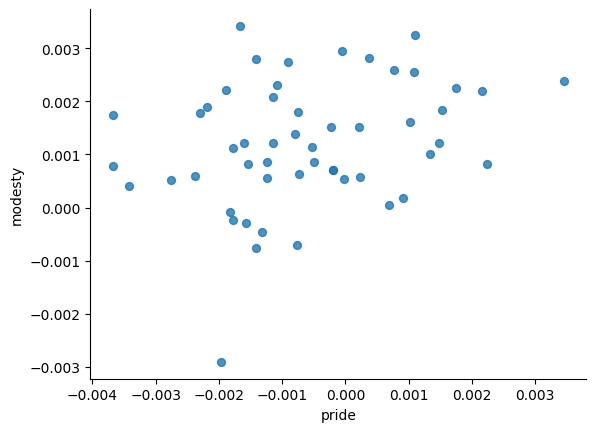

In [ ]:
# @title temperance vs liberality

from matplotlib import pyplot as plt
action_df_all_virtues.plot(kind='scatter', x='pride', y='modesty', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
mean_moral_projection = []
for virtue in mean_list:
  projection_moral = np.inner(np.array(virtue_emb_mean_df[virtue]),np.array(moral_v))
  mean_moral_projection.append(projection_moral)

mean_hedonic_projection = []
for virtue in mean_list:
  projection_hedonic = np.inner(np.array(virtue_emb_mean_df[virtue]),np.array(hedonic_v))
  mean_hedonic_projection.append(projection_hedonic)

mean_hedonic_projection

[0.0035439539589627216,
 0.013041784158429437,
 0.021794424374211488,
 0.028239504437976536,
 0.02773665137212591,
 0.022511865275231187,
 0.011248391555450297,
 0.013351995527582728,
 0.0208307033528823,
 0.026486677169619416,
 -0.002107214478687697,
 0.019922502444395866]

In [ ]:
#virtue_moral_hedonic_df = pd.DataFrame(index=mean_list, columns=['moral_v','hedonic_v'], data=[[mean_moral_projection],[mean_hedonic_projection]])
#virtue_moral_hedonic_df
virtue_moral_hedonic_df = pd.DataFrame(
    data= {'moral': mean_moral_projection,
     'hedonic': mean_hedonic_projection,
    },
    index=mean_list)

virtue_moral_hedonic_df

,moral,hedonic
courage,0.033242,0.003544
temperance,0.030927,0.013042
liberality,0.028638,0.021794
magnificence,0.037886,0.028240
magnanimity,0.038790,0.027737
pride,0.033119,0.022512
patience,0.026655,0.011248
truthfulness,0.033198,0.013352
wittiness,0.020617,0.020831
friendliness,0.032362,0.026487


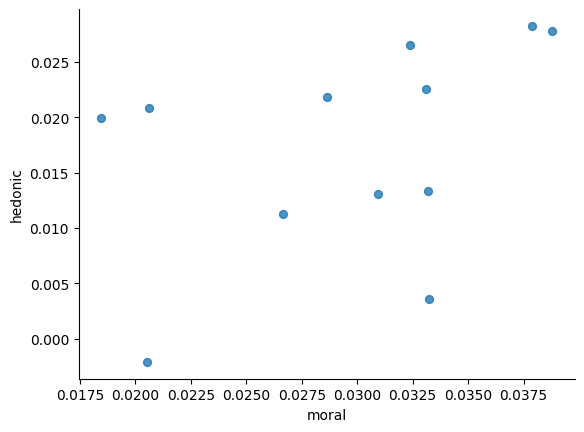

In [ ]:
virtue_moral_hedonic_df.plot(kind='scatter', x='moral', y='hedonic', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
def project_(stim_list, courage_v, temperance_v, liberality_v):
  '''
  get projections for list of items
  '''
  #construct dataframe to save items
  projection_df_ctl = pd.DataFrame(index=action_list_all, columns=list(virtue_emb_diff_df.columns.values), data=0)

  #loop through items to get embeddings in moral, hedonic, and movement vector directions

  for a in action_list_all:
    this_em = getEmbeddings(a)["data"][0]["embedding"]
    projection_moral = np.inner(np.array(this_em),np.array(courage_v))
    projection_hedonic = np.inner(np.array(this_em),np.array(temperance_v))
    projection_movement = np.inner(np.array(this_em),np.array(liberality_v))
    projection_df_ctl.loc[a, "courage_v"] = projection_moral
    projection_df_ctl.loc[a, "temperance_v"] = projection_hedonic
    projection_df_ctl.loc[a, "liberality_v"] = projection_movement

  return projection_df_ctl

In [ ]:
list(virtue_emb_diff_df.columns.values)[1]

'temperance'

In [ ]:
action_df = get_projections(action_list_all, courage_v, temperance_v, liberality_v)

<ipython-input-17-f8bfc06de9e3>:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.001066092301173007' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  projection_df_ctl.loc[a, "courage_v"] = projection_moral
<ipython-input-17-f8bfc06de9e3>:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.00036522485563000363' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  projection_df_ctl.loc[a, "temperance_v"] = projection_hedonic
<ipython-input-17-f8bfc06de9e3>:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.0010577199321673955' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  projection_df_ctl.loc[a, "liberality_v"] = project

In [ ]:
action_df

,courage_v,temperance_v,liberality_v
running a marathon for charity,0.001066,0.000365,0.001058
giving my employees a day off to go to the spa,-0.002025,-0.001487,0.003233
serving food to unhoused people in a soup kitchen,0.000642,0.000310,-0.000093
teaching English to refugees,-0.001726,0.001194,-0.000701
cleaning up litter in a rough neighborhood,-0.002128,-0.000520,0.003132
serving on a jury,0.000876,-0.000601,-0.001575
running a marathon for fitness,0.000139,-0.000878,-0.000521
winning millions in the lottery,-0.003688,-0.000867,0.003697
mowing the lawn,-0.003590,-0.001975,-0.000487
sitting in a chair,0.004677,-0.001235,0.001029


In [ ]:
def get_projections(stim_list, moral_v, hedonic_v, movement_v):
  '''
  get projections for list of items
  '''
  #construct dataframe to save items
  projection_df = pd.DataFrame(index=stim_list, columns=['courage_v','temperance_v','liberality_v'], data=0)

  #loop through items to get embeddings in moral, hedonic, and movement vector directions

  for a in stim_list:
    this_em = getEmbeddings(a)["data"][0]["embedding"]
    projection_moral = np.inner(np.array(this_em),np.array(moral_v))
    projection_hedonic = np.inner(np.array(this_em),np.array(hedonic_v))
    projection_movement = np.inner(np.array(this_em),np.array(movement_v))
    projection_df.loc[a, "courage_v"] = projection_moral
    projection_df.loc[a, "temperance_v"] = projection_hedonic
    projection_df.loc[a, "liberality_v"] = projection_movement

  return projection_df

In [ ]:
# get moral direction in GPT embeddings
attributes_morality_high = ['morally virtuous','ethical', 'high moral value']
attributes_morality_low = ['morally wrong','unethical', 'low moral value']
moral_v = return_embeddings_diff(attributes_morality_high, attributes_morality_low)

print(moral_v)

# get hedonic direction in GPT embeddings
attributes_hedonic_high = ['personally rewarding','pleasurable for me', 'high hedonic value for me']
attributes_hedonic_low = ['personally costly','unpleasurable for me', 'low hedonic value for me']
hedonic_v = return_embeddings_diff(attributes_hedonic_high, attributes_hedonic_low)

# get physicality direction in GPT embeddings
#attributes_movement_high = ['physical','bodily action', 'high movement']
#attributes_movement_low = ['mental','minimally active', 'low movement']
#movement_v = return_embeddings_diff(attributes_movement_high, attributes_movement_low)


          2         1         0
2  1.000000  0.849759  0.875315
1  0.849759  1.000000  0.893319
0  0.875315  0.893319  1.000000
          2         1         0
2  1.000000  0.833950  0.891547
1  0.833950  1.000000  0.831318
0  0.891547  0.831318  1.000000
0       0.013077
1      -0.004362
2      -0.004571
3       0.002126
4       0.019575
          ...   
1531    0.003848
1532    0.012578
1533   -0.001828
1534   -0.002859
1535   -0.000449
Length: 1536, dtype: float64
          2         1         0
2  1.000000  0.856273  0.806584
1  0.856273  1.000000  0.804478
0  0.806584  0.804478  1.000000
          2         1         0
2  1.000000  0.881714  0.822901
1  0.881714  1.000000  0.844764
0  0.822901  0.844764  1.000000


In [ ]:
# Report correlation among attribute embeddings
print('Embedding Correlations:')
print('r(courage, temperance) = '+ str(round(np.corrcoef(courage_v, temperance_v)[0, 1], 2)))
print('r(courage, liberality) = '+ str(round(np.corrcoef(courage_v, liberality_v)[0, 1], 2)))
print('r(temperance, liberality) = '+ str(round(np.corrcoef(temperance_v, liberality_v)[0, 1], 2)))


Embedding Correlations:
r(courage, temperance) = 0.16
r(courage, liberality) = -0.57
r(temperance, liberality) = -0.4


## generate projections on embeddings

In [ ]:
# get projections of stimuli onto each vector direction
#item_projections = get_projections(action_list_all, moral_v, hedonic_v, movement_v, social_v)
excess_projections = get_projections(excess_list, moral_v, hedonic_v, movement_v)
deficiency_projections = get_projections(deficiency_list, moral_v, hedonic_v, movement_v)
mean_projections = get_projections(mean_list, moral_v, hedonic_v, movement_v)

item_projections["item"] = item_projections.index

<ipython-input-81-9a4e52498519>:77: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.008128498181515299' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  projection_df.loc[a, "moral_v"] = projection_moral
<ipython-input-81-9a4e52498519>:78: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.00906591482654647' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  projection_df.loc[a, "hedonic_v"] = projection_hedonic
<ipython-input-81-9a4e52498519>:79: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.02234547954340919' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  projection_df.loc[a, "movement_v"] = projection_movement
<ipython-

In [ ]:
data = {'excess': virtue_data['excess'],
        'excess value': excess_projections['moral_v'].tolist(),
        'mean': virtue_data['mean'],
        'mean value': mean_projections['moral_v'].tolist(),
        'deficiency': virtue_data['deficiency'],
        'deficiency value': deficiency_projections['moral_v'].tolist()
}


In [ ]:
df = pd.DataFrame(data)
df

,excess,excess value,mean,mean value,deficiency,deficiency value
0,rashness,-0.008128,courage,0.033223,cowardice,-0.015978
1,licentiousness,-0.013024,temperance,0.030826,insensibility,-0.020047
2,prodigality,0.002157,liberality,0.028609,meanness,-0.017838
3,vulgarity,-0.020713,magnificence,0.037803,pettiness,-0.018463
4,vanity,0.014390,magnanimity,0.039045,pusillanimity,0.013066
5,ambition,0.022900,pride,0.033071,unambitiousness,-0.008197
6,irascibility,0.007597,patience,0.026559,unirascibility,0.005336
7,boastfulness,0.028848,truthfulness,0.033105,understatement,-0.021524
8,buffoonery,-0.024381,wittiness,0.020567,boorishness,-0.012465
9,obsequiousness,0.017199,friendliness,0.032258,cantankerousness,0.008617


In [ ]:
print('Item Embedding Projection Correlations:')
print('r(moral, hedonic) = '+ str(round(np.corrcoef(item_projections["moral_v"], item_projections["hedonic_v"])[0, 1], 3)))
print('r(moral, movement) = '+ str(round(np.corrcoef(item_projections["moral_v"], item_projections["movement_v"])[0, 1], 3)))
print('r(hedonic, movement) = '+ str(round(np.corrcoef(item_projections["hedonic_v"], item_projections["movement_v"])[0, 1], 3)))


Item Embedding Projection Correlations:
r(moral, hedonic) = 0.81
r(moral, movement) = 0.185
r(hedonic, movement) = 0.499


<ipython-input-16-36cdd83c0fbc>:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.annotate(plot_i, (item_projections_1['hedonic_v'][i]+.0005, item_projections_1['moral_v'][i]-.0001))


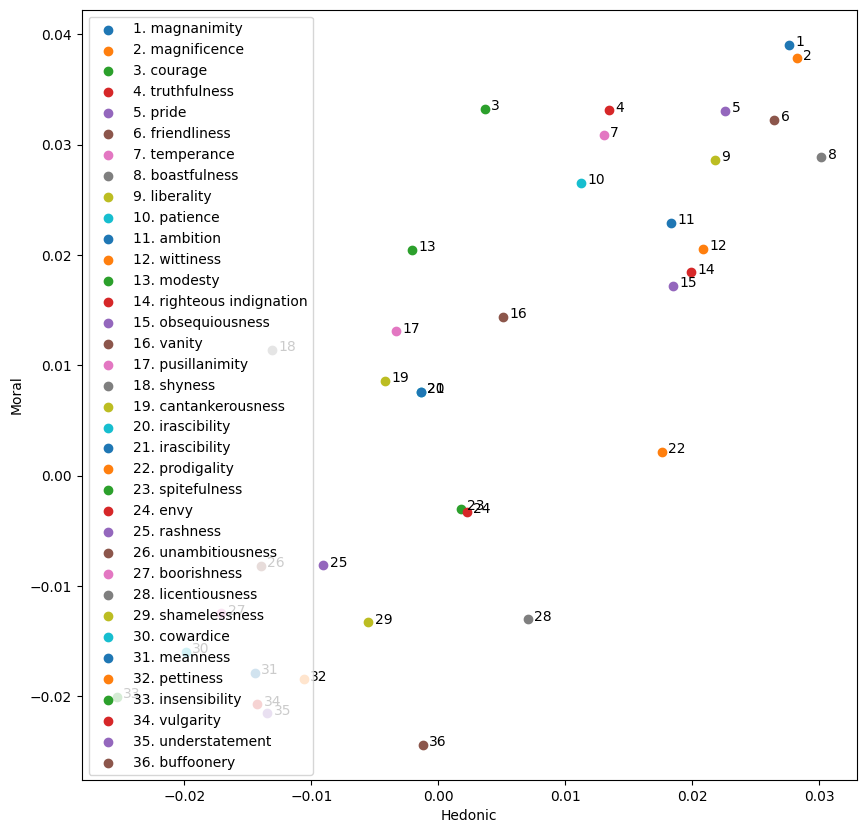

In [ ]:
# Plot Embeddings for Moral x Hedonic

# sort projections by morality before plotting
item_projections_1 = item_projections.sort_values('moral_v', ascending=False)


fig, ax = plt.subplots(figsize=(10, 10))
cmap = plt.get_cmap("tab20")

plot_i = 1
for i in range(len(item_projections_1)):
    x = item_projections_1['hedonic_v'].iloc[i]
    y = item_projections_1['moral_v'].iloc[i]
    colors = cmap(i/len(item_projections_1))
    l = str(plot_i) + '. ' + item_projections_1.index[i].lstrip('[').rstrip(']')
    ax.scatter([x],[y], label=l)
    ax.annotate(plot_i, (item_projections_1['hedonic_v'][i]+.0005, item_projections_1['moral_v'][i]-.0001))
    plot_i += 1

ax.set_xlabel('Hedonic')
ax.set_ylabel('Moral')
ax.legend()

# Sort-Rate Prompting (GPT-3.5)

In [ ]:
# @title define functions


def promptGPT(prompt_message_list, gpt_temperature=0):
  gpt_url = "https://api.openai.com/v1/chat/completions"
  gpt_headers = {
    "Content-Type": "application/json",
    "Authorization": userdata.get('OAI')
    }
  gpt_data = {
        "model": "gpt-3.5-turbo-1106",
        "response_format": {"type": "json_object"}, # only works on 3.5-turbo-1106, 4 and above
        "temperature": gpt_temperature,
        "messages": prompt_message_list,
    }
  response = requests.post(gpt_url, headers=gpt_headers, json=gpt_data)
  output = response.json()['choices'][0]['message']['content']

  return output

def prompt_sort(action_list, dimension, context=""):
  """
  Given a list of actions to sort, and a dimension to sort them on, craft a prompt
  for GPT, with example calls and responses.

  Optionally, include context regarding the hypothetical rater (Ziv),
  which may influence the ranking results.

  Returns a list of dicts to pass on to GPT as prompt messages
  """

  #randomize the order of the list
  random.shuffle(action_list)

  #turn list into formatted string
  action_string = (', ').join(action_list)

  # Switch by sorting dimension
  if dimension == 'moral':

    system_prompt_content = """You are an expert judge of the relative moral virtues of different actions.
Moral actions are those which humans consider virtuous, that consider others' wellbeing and happiness, and that are guided by principles of ethics.
You will be given a list of actions that an average human person, Ziv, is considering.
You must sort them in terms of their relative moral virtue according to Ziv.
You will recieve a JSON object of items to rate. This object will have the following key / value pairs:
1. actions - Array<string>: an unsorted list of actions that the user has been faced with
2. context - string: information that you can use to help you make your choice
You must respond with a JSON packet with a single key / value pair:
1. ranking - Array<string>: A sorted list of actions, starting with the most morally wrong, and ending with the most morally virtuous from Ziv's perpsective."""
    system_prompt= {
        "role": "system",
        "content": system_prompt_content
    }
    user_example = {
        "role": "user",
        "content": json.dumps({"actions": ["walk a dog", "rob a bank", "rescue a cat", "steal food"],
                               "context": ""}) # Initial example has no context
    }
    assistant_example = {
        "role": "assistant",
        "content": json.dumps({"ranking": ["rob a bank", "steal food", "walk a dog", "rescue a cat"]})
    }

  elif dimension == 'hedonic':

    system_prompt_content = """You are an expert judge of the relative hedonic reward of different actions.
Hedonically rewarding actions are those which humans consider pleasant, make them feel happy, and benefit their own wellbeing.
You will be given a list of actions that an average human person, Ziv, is considering.
You must sort them in terms of their relative hedonic reward for Ziv.
You will recieve a JSON object of items to rate. This object will have the following key / value pairs:
1. actions - Array<string>: an unsorted list of actions that the user has been faced with
2. context - string: information that you can use to help you make your choice
You must respond with a JSON packet with a single key / value pair:
1. ranking - Array<string>: A sorted list of actions, starting with the
worst and least hedonically rewarding, and ending with the best and most hedonically rewarding from Ziv's perpsective."""
    system_prompt= {
        "role": "system",
        "content": system_prompt_content
    }
    user_example = {
        "role": "user",
        "content": json.dumps({"actions": ["miss the bus", "win a sweepstakes", "eat a meal", "lose my wallet"],
                               "context": ""}) # Initial example has no context
    }
    assistant_example = {
        "role": "assistant",
        "content": json.dumps({"ranking": ["lose my wallet", "miss the bus", "eat a meal", "win a sweepstakes"]})
    }

  elif dimension == 'movement':

    system_prompt_content = """You are an expert judge of the physical body movement
of different actions. Physically active actions are those which humans consider to involve substantial movement of the body.
You will be given a list of actions that an average human person, Ziv, is considering.
You must sort them in terms of how much physical movement they involve.
You will recieve a JSON object of items to rate. This object will have the following key / value pairs:
1. actions - Array<string>: an unsorted list of actions that the user has been faced with
2. context - string: information that you can use to help you make your choice
You must respond with a JSON packet with a single key / value pair:

1. ranking - Array<string>: A sorted list of actions, starting with the
least physical body movement, and ending with the most physical body movement."""
    system_prompt= {
        "role": "system",
        "content": system_prompt_content
    }
    user_example = {
        "role": "user",
        "content": json.dumps({"actions": ["play soccer", "listen to music", "pack boxes", "order coffee at a cafe"],
                               "context": ""}) # Initial example has no context
    }
    assistant_example = {
        "role": "assistant",
        "content": json.dumps({"ranking": ["listen to music", "order coffee at a cafe", "pack boxes", "play soccer"]})
    }

  else:
    raise Exception("Specify a rating dimension: moral, hedonic, movement")


  # List actions to sort
  user_prompt = {
      "role": "user",
      "content": json.dumps({"actions": action_list,
                             "context": context}) # Optional context, defaults to empty string
  }

  return [system_prompt, user_example, assistant_example, user_prompt]


def prompt_rate_sorted(action_list, dimension, context=""):
  """
  Given a sorted list of actions to rate, and a dimension to sort them on, craft a prompt
  for GPT, with example calls and responses.

  Optionally, include context regarding the hypothetical rater (Ziv),
  which may influence the rating results.

  Returns a list of dicts to pass on to GPT as prompt messages
  """

  #turn list into formatted string
  action_string = (', ').join(action_list)

  # Switch by sorting dimension
  if dimension == 'moral':

    system_prompt_content = """You are an expert judge of the relative moral virtues of different actions.
Moral actions are those which humans consider virtuous, that consider others' wellbeing and happiness, and that are guided by principles of ethics.
You will be given a list of actions that an average human person, Ziv, is considering.
They are already sorted in terms of their relative moral virtue according to Ziv.
You will assign a number to each adjacent pair, rating 0 if the actions are very similar in terms of moral virtue, and 10 if the actions are very different in terms of moral virtue.
You will give the first action a rating of 0. You will give the second action a rating in comparison to the first action, and so on.
You will recieve a JSON object of items to rate. This object will have the following key / value pairs:
1. actions - Array<string>: a sorted list of actions that the user has been faced with
2. context - string: information that you can use to help you make your choice
You must respond with a JSON packet with a single key / value pair:
1. ranking - Array: A list of lists, each list contains 2 elements:
1. action from the original list
2. similarity rating from 0 to 10 between this action and the previous action in the list"""

    system_prompt= {
        "role": "system",
        "content": system_prompt_content
    }
    user_example = {
        "role": "user",
        "content": json.dumps({"actions": ["rob a bank", "steal food", "walk a dog", "rescue a cat"],
                               "context": ""}) # Initial example has no context
    }
    assistant_example = {
        "role": "assistant",
        "content": json.dumps({"ranking": [["rob a bank", 0], ["steal food", 3], ["walk a dog", 10], ["rescue a cat", 6]]})
    }

  elif dimension == 'hedonic':

    system_prompt_content = """You are an expert judge of the relative hedonic reward
of different actions. Hedonically rewarding actions are those which humans consider pleasant, make them feel happy, and benefit their own wellbeing.
You will be given a list of actions that an average human person, Ziv, is considering.
They are already sorted in terms of their relative hedonic reward for Ziv.
You will assign a number to each adjacent pair, rating 0 if the actions are very similar
in terms of hedonic reward, and 10 if the actions are very different in terms of hedonic reward.
You will give the first action a rating of 0. You will give the second action a rating in comparison to the first action, and so on.
You will recieve a JSON object of items to rate. This object will have the following key / value pairs:
1. actions - Array<string>: a sorted list of actions that the user has been faced with
2. context - string: information that you can use to help you make your choice
You must respond with a JSON packet with a single key / value pair:
1. ranking - Array: A list of lists, each list contains 2 elements:
1. action from the original list
2. similarity rating from 0 to 10 between this action and the previous action in the list"""

    system_prompt= {
        "role": "system",
        "content": system_prompt_content
    }
    user_example = {
        "role": "user",
        "content": json.dumps({"actions": ["lose my wallet", "miss the bus", "eat a meal", "win a sweepstakes"],
                               "context": ""}) # Initial example has no context
    }
    assistant_example = {
        "role": "assistant",
        "content": json.dumps({"ranking": [["lose my wallet", 0], ["miss the bus", 2], ["eat a meal", 9], ["win a sweepstakes", 8]]})
    }

  elif dimension == 'movement':

    system_prompt_content = """You are an expert judge of the physical body movement of different actions.
Physically active actions are those which humans consider to involve substantial movement of the body.
You will be given a list of actions that an average human person, Ziv, is considering.
They are already sorted in terms of how much physical movement they involve.
You will assign a number to each adjacent pair, rating 0 if the actions are very similar
in terms of amount of physical movement, and 10 if the actions are very different in terms of amount of physical movement.
You will give the first action a rating of 0. You will give the second action a rating in comparison to the first action, and so on.
You will recieve a JSON object of items to rate. This object will have the following key / value pairs:
1. actions - Array<string>: a sorted list of actions that the user has been faced with
2. context - string: information that you can use to help you make your choice
You must respond with a JSON packet with a single key / value pair:
1. ranking - Array: A list of lists, each list contains 2 elements:
1. action from the original list
2. similarity rating from 0 to 10 between this action and the previous action in the list"""

    system_prompt= {
        "role": "system",
        "content": system_prompt_content
    }
    user_example = {
        "role": "user",
        "content": json.dumps({"actions": ["listen to music", "order coffee at a cafe", "pack boxes", "play soccer"],
                               "context": ""}) # Initial example has no context
    }
    assistant_example = {
        "role": "assistant",
        "content": json.dumps({"ranking": [["listen to music", 0], ["order coffee at a cafe", 2], ["pack boxes", 6], ["play soccer", 9]]})
    }

  else:
    raise Exception("Specify a rating dimension: moral, hedonic, movement")


  # List actions to sort
  user_prompt = {
      "role": "user",
      "content": json.dumps({"actions": action_list,
                             "context": context}) # Optional context, defaults to empty string
  }

  return [system_prompt, user_example, assistant_example, user_prompt]

def sort_rate(action_list, dimension):

  # Sort actions
  resp = promptGPT(prompt_sort(action_list, dimension))
  resp_sorted_list = json.loads(resp)['ranking']

  # Rate distance between sorted actions
  resp = promptGPT(prompt_rate_sorted(resp_sorted_list, dimension))
  resp_rated_list = json.loads(resp)['ranking']

  # parse the ratings into a dataframe
  resp_df = pd.DataFrame(resp_rated_list, columns=['item', 'rating'])
  resp_df['rating'] = pd.to_numeric(resp_df['rating'])
  resp_df['rating_sum'] = resp_df['rating'].cumsum()
  resp_df['rescored_' + dimension] = resp_df['rating_sum'] / resp_df['rating_sum'].max() * 100
  resp_df = resp_df.drop(columns=['rating', 'rating_sum'])

  return resp_df

In [ ]:
# # Create list of lists with all items
niter = 100
dimension = 'hedonic'
n_items = len(action_list_all)
result_lists = [[action, []] for action in action_list_all]

for i in range(niter):
  result_df = []
  print(i)

  count=0
  check=False
  while(check==False):
    print(check)
    result_df = sort_rate(action_list_all, dimension)
    count = count+1
    a = set(list(result_df['item']))
    b = set(action_list_all)
    if(len(b.difference(a))==0):
      check=True
    else:
      check=False
    print(count)


0
False
1
False
2
False
3
False
4
False
5
False
6
False
7
False
8
False
9
False
10
False
11
False
12
False
13
False
14
False
15
False
16
False
17
False
18
False
19
False
20
False
21
False
22
False
23
False
24
False
25
False
26
False
27
False
28
False
29
False
30
False
31
False
32
False
33
False
34
False
35
False
36
False
37
False
38
False
39
False
40
False
41
False
42
False
43
False
44
False
45
False
46
False
47
False
48
False
49
False
50
False
51
False
52
False
53
False
54
False
55
False
56
False
57
False
58
False
59
False
60
False
61
False
62
False
63
False
64
False
65
False
66
False
67
False
68
False
69
False


JSONDecodeError: Unterminated string starting at: line 1 column 17562 (char 17561)

In [ ]:
 for action in action_list_all:
    act_val = result_df[result_df['item'] == action]['rescored_'+ dimension].values[0]
    cur_vals = []
    for row in result_lists:
      if row[0] == action:
        row[1].append(act_val)
        break

IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
#summary statistics for each item
stats_results_lists = []

for row in result_lists:
  if len(row[1]) > 0:
    CI = st.t.interval(0.95, len(row[1])-1, loc=np.mean(row[1]), scale=st.sem(row[1]))
    new_row = [
        row[0],
        max(0, CI[0]), # 0 or low CI
        np.mean(row[1]),
        min(100, CI[1]), # 100 or high CI
        ]
    stats_results_lists.append(new_row)
  else:
    print('Need more data for ' + row[0])

stat_results_df = pd.DataFrame(stats_results_lists, columns=['item', '95CI_Low', 'mean', '95CI_High'])

## read in prompting data from past results

In [ ]:

moral_df_stats = pd.read_csv(data_path + 'moral_100_iter_results.csv')
hedonic_df_stats =  pd.read_csv(data_path + 'hedonic_100_iter_results.csv')
movement_df_stats =  pd.read_csv(data_path + 'movement_100_iter_results.csv')

moral_df_stats.columns = ['null', 'item', 'low_moral', 'mean_moral', 'high_moral']
hedonic_df_stats.columns = ['null', 'item', 'low_hedonic', 'mean_hedonic', 'high_hedonic']
movement_df_stats.columns = ['null', 'item', 'low_movement', 'mean_movement', 'high_movement']

moral_df_stats = moral_df_stats.drop(columns=['null'])
hedonic_df_stats = hedonic_df_stats.drop(columns=['null'])
movement_df_stats = movement_df_stats.drop(columns=['null'])


full_df = pd.merge(moral_df_stats, hedonic_df_stats, on='item', how='inner')
full_df = pd.merge(full_df, movement_df_stats, on='item', how='inner')

#now subset to the items of concern here
full_df_prompting = full_df[full_df["item"].isin(action_list_all)]


NameError: name 'data_path' is not defined

## analyze prompting data

In [ ]:
print('Prompting Correlations:')
print('r(moral, hedonic) = '+ str(round(np.corrcoef(full_df_prompting["mean_moral"], full_df_prompting["mean_hedonic"])[0, 1], 3)))
print('r(moral, movement) = '+ str(round(np.corrcoef(full_df_prompting["mean_moral"], full_df_prompting["mean_movement"])[0, 1], 3)))
print('r(hedonic, movement) = '+ str(round(np.corrcoef(full_df_prompting["mean_hedonic"], full_df_prompting["mean_movement"])[0, 1], 3)))

In [ ]:
#@title generate plots
full_df_prompting_sorted = full_df_prompting.sort_values('mean_moral', ascending=False)

fig, ax = plt.subplots(figsize=(10, 10))

plot_i = 1
for i in range(len(full_df_prompting_sorted)):

    # X axis, means with 95% CI low and high values
    x = full_df_prompting_sorted['mean_hedonic'].iloc[i]
    x_l = full_df_prompting_sorted['mean_hedonic'].iloc[i] - full_df_prompting_sorted['low_hedonic'].iloc[i]
    x_h = full_df_prompting_sorted['high_hedonic'].iloc[i] - full_df_prompting_sorted['mean_hedonic'].iloc[i]

    # Y axis, means with 95% CI low and high values
    y = full_df_prompting_sorted['mean_moral'].iloc[i]
    y_l = full_df_prompting_sorted['mean_moral'].iloc[i] - full_df_prompting_sorted['low_moral'].iloc[i]
    y_h = full_df_prompting_sorted['high_moral'].iloc[i] - full_df_prompting_sorted['mean_moral'].iloc[i]

    l = str(plot_i) + '. ' + full_df_prompting_sorted['item'].iloc[i].lstrip('[').rstrip(']')
    ax.errorbar(x, y, xerr=[[x_l], [x_h]], yerr=[[y_l], [y_h]], label=l, fmt='o', ecolor='lightgray', elinewidth=2)
    ax.annotate(plot_i, (x+.3, y+.5))

    plot_i += 1

ax.set_xlabel('Hedonic')
ax.set_ylabel('Moral')
ax.legend()

In [ ]:
data_table.DataTable(full_df_prompting_sorted, include_index = False, num_rows_per_page = 20)

# Direct Judgment/ Likert Rating Prompt (GPT-3.5)

In [ ]:
# @title define functions


def prompt_rate(action_list, dimension, context=""):
  """
  Given a list of actions to sort, and a dimension to sort them on, craft a prompt
  for GPT, with example calls and responses.

  Optionally, include context regarding the hypothetical rater (Ziv),
  which may influence the ranking results.

  Returns a list of dicts to pass on to GPT as prompt messages
  """

  #randomize the order of the list
  random.shuffle(action_list)

  #turn list into formatted string
  action_string = (', ').join(action_list)

  # Switch by sorting dimension
  if dimension == 'moral':

    system_prompt_content = """You are an expert judge of the moral virtues of different actions.
Moral actions are those which humans consider virtuous, that consider others' wellbeing and happiness, and that are guided by principles of ethics.
You will be given a list of actions that an average human person, Ziv, is considering.
You must rate them in terms of their moral virtue according to Ziv.
You will recieve a JSON object of items to rate. This object will have the following key / value pairs:
1. actions - Array<string>: a sorted list of actions that the user has been faced with
2. context - string: information that you can use to help you make your choice
You must respond with a JSON packet with a single key / value pair:
1. rating - Array: A list of lists, each list contains 2 elements:
1. action from the original list
2. rating from 0 to 10 for this action, where 0 is the most morally wrong, and 10 is the most morally virtuous"""

    system_prompt= {
        "role": "system",
        "content": system_prompt_content
    }
    user_example = {
        "role": "user",
        "content": json.dumps({"actions": ["walk a dog", "rob a bank", "rescue a cat", "steal food"],
                               "context": ""}) # Initial example has no context
    }
    assistant_example = {
        "role": "assistant",
        "content": json.dumps({"rating": [["walk a dog", 5], ["rob a bank", 1],[ "rescue a cat",8],["steal food", 2]]})
    }

  elif dimension == 'hedonic':

    system_prompt_content = """You are an expert judge of the hedonic reward of different actions.
Hedonically rewarding actions are those which humans consider pleasant, make them feel happy, and benefit their own wellbeing.
You will be given a list of actions that an average human person, Ziv, is considering.
You must rate them in terms of their hedonic reward according to Ziv.
You will recieve a JSON object of items to rate. This object will have the following key / value pairs:
1. actions - Array<string>: a sorted list of actions that the user has been faced with
2. context - string: information that you can use to help you make your choice
You must respond with a JSON packet with a single key / value pair:
1. rating - Array: A list of lists, each list contains 2 elements:
1. action from the original list
2. rating from 0 to 10 for this action, where 0 is the least hedonically rewarding, and 10 is the most hedonically rewarding"""

    system_prompt= {
        "role": "system",
        "content": system_prompt_content
    }
    user_example = {
        "role": "user",
        "content": json.dumps({"actions": ["miss the bus", "win a sweepstakes", "eat a meal", "lose my wallet"],
                               "context": ""}) # Initial example has no context
    }
    assistant_example = {
        "role": "assistant",
        "content": json.dumps({"rating": [["miss the bus", 3], ["win a sweepstakes", 9], ["eat a meal", 7], ["lose my wallet", 2]]})
    }

  elif dimension == 'movement':

    system_prompt_content = """You are an expert judge of the physical body movement of different actions.
Physically active actions are those which humans consider to involve substantial movement of the body.
You will be given a list of actions that an average human person, Ziv, is considering.
You must rate them in terms of how much physical movement they involve.
You will recieve a JSON object of items to rate. This object will have the following key / value pairs:
1. actions - Array<string>: a sorted list of actions that the user has been faced with
2. context - string: information that you can use to help you make your choice
You must respond with a JSON packet with a single key / value pair:
1. rating - Array: A list of lists, each list contains 2 elements:
1. action from the original list
2. rating from 0 to 10 for this action, where 0 indicates the least physical body movement, and 10 indicates the most physical body movement"""

    system_prompt= {
        "role": "system",
        "content": system_prompt_content
    }
    user_example = {
        "role": "user",
        "content": json.dumps({"actions": ["play soccer", "listen to music", "pack boxes", "order coffee at a cafe"],
                               "context": ""}) # Initial example has no context
    }
    assistant_example = {
        "role": "assistant",
        "content": json.dumps({"rating": [["play soccer", 9], ["listen to music", 0], ["pack boxes", 6], ["order coffee at a cafe", 2]]})
    }

  else:
    raise Exception("Specify a rating dimension: moral, hedonic, movement")


  # List actions to sort
  user_prompt = {
      "role": "user",
      "content": json.dumps({"actions": action_list,
                             "context": context}) # Optional context, defaults to empty string
  }

  return [system_prompt, user_example, assistant_example, user_prompt]


## run iterative prompting and compute stats

In [ ]:

# Create list of lists with all items
resample_size = 20
dimension = 'movement'

result_lists = [[action, []] for action in action_list_all]

for i in range(resample_size):

  # Rate actions
  resp = promptGPT(prompt_rate(action_list_all, dimension))
  resp_list = json.loads(resp)['rating']
  resp_df = pd.DataFrame(resp_list, columns=['item', 'rating'])
  resp_df['rating'] = pd.to_numeric(resp_df['rating'])

  for action in action_list_all:
    act_val = resp_df[resp_df['item'] == action]['rating'].values[0]
    cur_vals = []
    for row in result_lists:
      if row[0] == action:
        row[1].append(act_val)
        break

In [ ]:
# summary statistics for each item
new_result_lists = []

for row in result_lists:
  if len(row[1]) > 0:
    CI = st.t.interval(0.95, len(row[1])-1, loc=np.mean(row[1]), scale=st.sem(row[1]))
    new_row = [
        row[0],
        max(0, CI[0]), # 0 or low CI
        np.mean(row[1]),
        min(10, CI[1]), # 10 or high CI
        ]
    new_result_lists.append(new_row)
  else:
    print('Need more data for ' + row[0])

new_results_df = pd.DataFrame(new_result_lists, columns=['item', '95CI_Low', 'mean', '95CI_High'])